# Covid data exploration and fitting

## Current status
1. 1.9.2020 Fixed Owid data extraction for compatibility with jhu (alignment of dates and datatypes, correction of tests)

## Setup

In [1]:
import numpy as np
import csv
import itertools
import matplotlib
%matplotlib inline
import seaborn as sb
from matplotlib import pyplot as plt
from cycler import cycler
import datetime
import matplotlib.dates as mdates
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import pwlf

/Users/n/.pyenv/versions/3.7.2/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
import sys
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
sys.executable


'/Users/n/.pyenv/versions/3.7.2/bin/python3'

In [4]:
matplotlib.__version__

'3.1.1'

In [5]:
def Float(x):
    try:
        rtn = float(x)
    except:
        rtn = float('NaN')
    return rtn

## JHU data and OWID data

In [6]:
def get_data(jhu_file):
    dat = []
    with open(jhu_file, newline='') as csvfile:
        myreader = csv.reader(csvfile, delimiter=',')
        popdat = []
        i = 0
        for row in myreader:
            if i != 0:
                poplist = []
                j = 0
                for elt in row:
                    if j >= 4:
                        poplist.append(int(elt))
                    elif j == 0:
                        poplist.append(elt)
                    elif j == 1:
                        poplist[0]=(elt,poplist[0])
                    j = j+1
                popdat.append(poplist)
            else:
                popdat.append(row)
            # print(popdat[i])
            i = i + 1;
    # dates
    popdat0=['dates']
    for elt in popdat[0][4:]:
        popdat0.append(elt)
    popdat[0] = [pop for pop in popdat0]
    print('popdat[0]',popdat[0])
    # totals over all countries
    totals = np.zeros(len(popdat[0])-1,dtype=int)
    for row in popdat[1:]:
        totals = totals + np.array(row[1:])
    totals = list(np.asarray(totals))
    # print(totals)
    popkeyed = {poplist[0]: poplist[1:] for poplist in popdat}
    popkeyed.update({'dates':popdat[0][1:]})
    popkeyed.update({('World',''):totals})
    # del popkeyed[('d','a')]
    # assemble totals for countries with multiple regions
    total = np.zeros(len(popkeyed['dates']),dtype=int)
    poptotkeyed = {}
    for country,tseries in popkeyed.items():
        if country!='dates' and country[1] != '':                           # seems that UK is single exception with both '' and non '' regions, UK total is then UK overseas
            countrytotal = (country[0],'Total')
            if countrytotal in poptotkeyed:
                # print(country,popkeyed[country],poptotkeyed[countrytotal])
                total = np.array(tseries)[:]+np.array(poptotkeyed[countrytotal])[:]
            else:
                total =  np.array(tseries)                        
            poptotkeyed.update({countrytotal:list(total)})
    for countrytotal,tseries in poptotkeyed.items():
        total = np.array(tseries)
        popkeyed.update({countrytotal:list(total)})
    return popkeyed

In [7]:
base = '../covid-19-JH/csse_covid_19_data/csse_covid_19_time_series/'
confirmed = get_data(base+'time_series_covid19_confirmed_global.csv')
deaths = get_data(base+'time_series_covid19_deaths_global.csv')
recovered = get_data(base+'time_series_covid19_recovered_global.csv')
covid_ts = {'confirmed':confirmed,'deaths':deaths,'recovered':recovered}
countries_jhu = [(row[0],row[1]) for row in confirmed][1:]
print("number of countries listed",len(countries_jhu))
i=0
for country in countries_jhu:
    print(i,country)
    i = i + 1

popdat[0] ['dates', '1/22/20', '1/23/20', '1/24/20', '1/25/20', '1/26/20', '1/27/20', '1/28/20', '1/29/20', '1/30/20', '1/31/20', '2/1/20', '2/2/20', '2/3/20', '2/4/20', '2/5/20', '2/6/20', '2/7/20', '2/8/20', '2/9/20', '2/10/20', '2/11/20', '2/12/20', '2/13/20', '2/14/20', '2/15/20', '2/16/20', '2/17/20', '2/18/20', '2/19/20', '2/20/20', '2/21/20', '2/22/20', '2/23/20', '2/24/20', '2/25/20', '2/26/20', '2/27/20', '2/28/20', '2/29/20', '3/1/20', '3/2/20', '3/3/20', '3/4/20', '3/5/20', '3/6/20', '3/7/20', '3/8/20', '3/9/20', '3/10/20', '3/11/20', '3/12/20', '3/13/20', '3/14/20', '3/15/20', '3/16/20', '3/17/20', '3/18/20', '3/19/20', '3/20/20', '3/21/20', '3/22/20', '3/23/20', '3/24/20', '3/25/20', '3/26/20', '3/27/20', '3/28/20', '3/29/20', '3/30/20', '3/31/20', '4/1/20', '4/2/20', '4/3/20', '4/4/20', '4/5/20', '4/6/20', '4/7/20', '4/8/20', '4/9/20', '4/10/20', '4/11/20', '4/12/20', '4/13/20', '4/14/20', '4/15/20', '4/16/20', '4/17/20', '4/18/20', '4/19/20', '4/20/20', '4/21/20', '4/22/

In [8]:
print(confirmed['dates'])

['1/22/20', '1/23/20', '1/24/20', '1/25/20', '1/26/20', '1/27/20', '1/28/20', '1/29/20', '1/30/20', '1/31/20', '2/1/20', '2/2/20', '2/3/20', '2/4/20', '2/5/20', '2/6/20', '2/7/20', '2/8/20', '2/9/20', '2/10/20', '2/11/20', '2/12/20', '2/13/20', '2/14/20', '2/15/20', '2/16/20', '2/17/20', '2/18/20', '2/19/20', '2/20/20', '2/21/20', '2/22/20', '2/23/20', '2/24/20', '2/25/20', '2/26/20', '2/27/20', '2/28/20', '2/29/20', '3/1/20', '3/2/20', '3/3/20', '3/4/20', '3/5/20', '3/6/20', '3/7/20', '3/8/20', '3/9/20', '3/10/20', '3/11/20', '3/12/20', '3/13/20', '3/14/20', '3/15/20', '3/16/20', '3/17/20', '3/18/20', '3/19/20', '3/20/20', '3/21/20', '3/22/20', '3/23/20', '3/24/20', '3/25/20', '3/26/20', '3/27/20', '3/28/20', '3/29/20', '3/30/20', '3/31/20', '4/1/20', '4/2/20', '4/3/20', '4/4/20', '4/5/20', '4/6/20', '4/7/20', '4/8/20', '4/9/20', '4/10/20', '4/11/20', '4/12/20', '4/13/20', '4/14/20', '4/15/20', '4/16/20', '4/17/20', '4/18/20', '4/19/20', '4/20/20', '4/21/20', '4/22/20', '4/23/20', '4/

In [9]:
country_Oxford_JHU = {}
country_Oxford_JHU.update({('Cape Verde', ''):('Cabo Verde', '')})
country_Oxford_JHU.update({('Aruba', ''):('Netherlands', 'Aruba')})
country_Oxford_JHU.update({('Bermuda', ''):('United Kingdom', 'Bermuda')})
country_Oxford_JHU.update({('Hong Kong', ''):('China', 'Hong Kong')})
country_Oxford_JHU.update({('Czech Republic', ''):('Czechia', '')})
country_Oxford_JHU.update({('China', ''):('China', 'Total')})          # split in database : sums to Total need to be done
country_Oxford_JHU.update({('Slovak Republic', ''):('Slovakia', '')})
country_Oxford_JHU.update({('Congo', ''):('Congo (Brazzaville)', '')}) # two Congos, this is Rep. of Congo, other is Democratic Republic of Congo
country_Oxford_JHU.update({('Democratic Republic of Congo', ''):('Congo-Kinshasa','')})
country_Oxford_JHU.update({('Solomon Islands', ''):('Solomon Islands', '')}) # Not present in JHU list: sovereign state poln 650000
country_Oxford_JHU.update({('South Korea', ''):('Korea, South', '')})
country_Oxford_JHU.update({('Turkmenistan', ''):('Turkmenistan', '')}) # Not present in JHU list: 5.6M people in Central Asia
country_Oxford_JHU.update({('Myanmar', ''):('Thailand', '')})
country_Oxford_JHU.update({('United States', '') : ('US', '')})
country_Oxford_JHU.update({('Australia', ''):('Australia', 'Total')})  # split in database : sums to Total need to be done
country_Oxford_JHU.update({('Puerto Rico', ''):('United States','Puerto Rico')})   # not found in inspection of JHU list, territory of US
country_Oxford_JHU.update({('Palestine', ''):('West Bank and Gaza', '')})
country_Oxford_JHU.update({('Timor', ''):('Timor-Leste', '')})         # check two Timors, East Timor
country_Oxford_JHU.update({('Canada', ''):('Canada', 'Total')})        # split in database : sums to Total need to be done
country_Oxford_JHU.update({('Greenland', ''):('Denmark', 'Greenland')})
country_Oxford_JHU.update({('Macao', ''):('China', 'Macau')})
country_Oxford_JHU.update({('Kyrgyz Republic', ''):('Kyrgyzstan', '')})
country_Oxford_JHU.update({('Taiwan', ''):('Taiwan*', '')})
country_Oxford_JHU.update({('Guam', ''):('United States','Guam')})     # not found in inspection of JHU list, territory of US

In [10]:
def plotCountry(country_s, datatype='confirmed', dataaccum='cumulative', fittype=None, ax=None, ax2=False,
                symbol='o--', step=None, firstdate=None, lastdate=None, intdates=False, linecolor=None):
    """ plots selected data for a list of countries or single country
        datatypes allowed are 'confirmed','deaths','recovered'
        dataaccum specifies either 'cumulative' or 'daily' or averaged over 7 days 'cum_av_weekly' or 'daily_av_weekly'
        fittypes allowed are currently None, 'piecewise-linear'
        ax graphical axes to use for plot: default None -> new axes
        ax2 true if second axes as twin axes for overlay plotting
        symbol to use for plotting
        step whether to use step plotting instead of points: default None -> points
        firstdate to plot (maybe before first date in data - pad with 0)
        lastdate to plot (maybe after last date in data - pad with 0)
        intdates : whether to plot dates as integers for compatibility (default as dates)
        linecolor is default color to use for a single trace, instead of listed set)
    """
    # extract list of countries in [(country,region),...] format from first parameter
    countries = []
    if isinstance(country_s,list):
        for country in country_s:
            if isinstance(country,str):
                country = (country,'')
            countries.append(country)
    elif isinstance(country_s,str):
        countries = [(country_s,'')]
    else:                               # single ('country','reg') entry
        countries = [country_s]
        
    # get data with datatype and extend dates to padd desired interval specified by firstdate,lastdate
    popkeyed = covid_ts[datatype]
    dates = popkeyed['dates']
    fmt = '%m/%d/%y'
    xx = [datetime.datetime.strptime(dd,fmt) for dd in dates ]
    if firstdate:
        firstdate_d = datetime.datetime.strptime(firstdate,fmt)
    else:
        firstdate_d = datetime.datetime.strptime(dates[0],fmt)
    if lastdate:
        lastdate_d = datetime.datetime.strptime(lastdate,fmt)
    else:
        lastdate_d = datetime.datetime.strptime(dates[-1],fmt)
    daystart = (firstdate_d-xx[0]).days
    daystop = (lastdate_d-xx[-1]).days
    if daystart <0:
        xx0 = [xx[0]+datetime.timedelta(days=i) for i in range(daystart,0)]
        yy0 = [0.]*(-daystart)
    else:
        xx0 = []
        yy0 = []
    if daystop > 0:
        xx1 = [xx[-1]+datetime.timedelta(days=i) for i in range(daystop)]
        yy1 = [0.]*(daystop)
    else:
        xx1 = []
        yy1 = []       
    xx = xx0 + xx + xx1
    
    # print('len xx',len(xx))
    if fittype == 'piecewise-linear':
        xxi = [Float((x-firstdate_d).days) for x in xx ]
        # print(xxi)
        
    # locator = mdates.MonthLocator()
    locator = mdates.AutoDateLocator(minticks=5, maxticks=13)
    formatter= mdates.ConciseDateFormatter(locator)
    
    if not ax:
        fig,ax = plt.subplots(1,1,figsize=(20,10)) 
        ax2 = ax
    elif ax2:
        ax2 = ax.twinx()
    else:
        ax2 = ax
    colors =  ['k', 'b', 'c', 'm', 'y', 'g', 'olive', 'chocolate']
        
    i = 0
    j = 0
    for country in countries:
        try:
            yy = popkeyed[country]
            j = j+1
        except:
            print('country not found',country)
            i = i + 1
            continue
        yyf = [Float(y) for y in yy]
        yy = yy0 + yyf + yy1
        # print('len yy',len(yy))
        # ymax=np.max(np.array(yy))
        yyf = [Float(y) for y in yy]
        if dataaccum == 'daily':
            yy = [0.]*len(yy)
            yy[0] = yyf[0]
            for k in range(1,len(yy)):
                yy[k] = yyf[k]-yyf[k-1]   
        elif dataaccum == 'cum_av_weekly':
            yy = [0.]*len(yy)
            moving_av = 0.
            for k in range(len(yy)):
                if k-7 >= 0:
                    moving_av = moving_av - yyf[k-7]
                moving_av = moving_av + yyf[k]
                yy[k] = moving_av/min(7.0,float(k+1))
        elif dataaccum == 'daily_av_weekly':
            yy = [0.]*len(yyf)
            yy[0] = yyf[0]
            for k in range(1,len(yy)):
                yy[k] = yyf[k]-yyf[k-1]
            yyf = [y for y in yy]
            yy = [0.]*len(yy)
            moving_av = 0.
            for k in range(len(yy)):
                if k-7 >= 0:
                    moving_av = moving_av - yyf[k-7]
                moving_av = moving_av + yyf[k]
                yy[k] = moving_av/min(7.0,float(k+1))
        if intdates:
            xx = range(len(xx))
        if step:
            ax2.step(xx,yy,label = country[0])
        else:
            # print(ax,ax2)
            # ax2.set_ylim(ymax,0)
            if linecolor:
                color = linecolor
            else:
                color = colors[i]
            ax2.plot(xx, yy, symbol, color = color, alpha=0.8, label = country[0])

        plt.title(country[0]+'-'+country[1])  # +' '+datatype)
        if fittype == 'piecewise-linear':    
            # initialize piecewise linear fit with your x and y data
            yyf = [Float(y) for y in yy]
            my_pwlf = pwlf.PiecewiseLinFit(xxi, yyf)
            # fit the data for three line segments
            res = my_pwlf.fit(3)
            # predict for the determined points
            xHat = np.linspace(min(xxi), max(xxi), num=len(xx))
            # print(len(xHat),len(xxi))
            yHat = my_pwlf.predict(xHat)
            ax2.plot(xx, yHat, color = colors[i], alpha=0.5, label = country[0]+' fit')
        i = i+1

    if j==0:
        ax.axis("off")
    else:
        if j > 1:
            plt.legend(loc="upper left")
            plt.title('countries '+datatype+dataaccum)
        if not intdates:
            ax2.xaxis.set_major_formatter(formatter)
            ax2.xaxis.set_major_locator(locator)
            for tick in ax2.get_xticklabels():
                tick.set_rotation(40)



In [11]:
owid_file = '../covid-19-owid/public/data/owid-covid-data.csv'
covid_owid = []
with open(owid_file,'r',newline='') as fp:
    myreader = csv.DictReader(fp,delimiter=',')
#    rows = list(itertools.islice(myreader,4))
    for row in myreader:
        covid_owid.append(row)
covid_owid[0].keys()

odict_keys(['iso_code', 'continent', 'location', 'date', 'total_cases', 'new_cases', 'new_cases_smoothed', 'total_deaths', 'new_deaths', 'new_deaths_smoothed', 'total_cases_per_million', 'new_cases_per_million', 'new_cases_smoothed_per_million', 'total_deaths_per_million', 'new_deaths_per_million', 'new_deaths_smoothed_per_million', 'new_tests', 'total_tests', 'total_tests_per_thousand', 'new_tests_per_thousand', 'new_tests_smoothed', 'new_tests_smoothed_per_thousand', 'tests_per_case', 'positive_rate', 'tests_units', 'stringency_index', 'population', 'population_density', 'median_age', 'aged_65_older', 'aged_70_older', 'gdp_per_capita', 'extreme_poverty', 'cardiovasc_death_rate', 'diabetes_prevalence', 'female_smokers', 'male_smokers', 'handwashing_facilities', 'hospital_beds_per_thousand', 'life_expectancy'])

In [17]:
len(covid_owid[0].keys()

40

In [20]:
keys_ow = [k for k in covid_owid[0].keys()]
print(keys_ow)

['iso_code', 'continent', 'location', 'date', 'total_cases', 'new_cases', 'new_cases_smoothed', 'total_deaths', 'new_deaths', 'new_deaths_smoothed', 'total_cases_per_million', 'new_cases_per_million', 'new_cases_smoothed_per_million', 'total_deaths_per_million', 'new_deaths_per_million', 'new_deaths_smoothed_per_million', 'new_tests', 'total_tests', 'total_tests_per_thousand', 'new_tests_per_thousand', 'new_tests_smoothed', 'new_tests_smoothed_per_thousand', 'tests_per_case', 'positive_rate', 'tests_units', 'stringency_index', 'population', 'population_density', 'median_age', 'aged_65_older', 'aged_70_older', 'gdp_per_capita', 'extreme_poverty', 'cardiovasc_death_rate', 'diabetes_prevalence', 'female_smokers', 'male_smokers', 'handwashing_facilities', 'hospital_beds_per_thousand', 'life_expectancy']


In [ ]:
# arrange owid data by country
countries_ow = np.unique(np.array([dd['location'] for dd in covid_owid]))
dates = np.unique(np.array([dd['date'] for dd in covid_owid]))
dates.sort()
fmt = '%Y-%m-%d'
dates_t = [datetime.datetime.strptime(dd,fmt) for dd in dates ]
firstdate = dates[0]
lastdate = dates[-1]
firstdate_t =  dates_t[0]
lastdate_t =  dates_t[-1]
daystart = 0
daystop = (lastdate_t-firstdate_t).days

owid_file = '../covid-19-owid/public/data/owid-covid-data.csv'



cur = 'Afghanistan'


with open(owid_file,'r',newline='') as fp:
    myreader = csv.DictReader(fp,delimiter=',')
#    rows = list(itertools.islice(myreader,4))
    for row in myreader:
        if
        covid_owid.append(row)
for cc in countries_ow:
    dat[cc] = {kk:np.zeros(daystop+1,dtype=float) for kk in keys_data_ow}
covid_owid[0].keys()

In [43]:
popkeyed = {country: np.zeros(daystop+1,dtype=float) for country in countries_ow} 

keys_data_ow = keys_ow[4:]
dat = {}
for cc in countries_ow:
    datestmp = np.unique(np.array([dd['date'] for dd in covid_owid if dd['location']==cc]))
    dat[cc] = {kk:np.zeros(daystop+1,dtype=float) for kk in keys_data_ow}
    for dd in datestmp:
        idx = [i for i,x in enumerate(dates) if x==dd] # idx = location of dd in array of all dates
        if len(idx)>1:
            print('ouch')
        else:
            idx = idx[0]
        for kk in keys_data_ow:
            val = [Float(dcowid[kk])  for dcowid in covid_owid if dcowid['location']==cc and dcowid['date']==dd]
            if len(val)>1:
                print('ouchouch')
            else:
                val = val[0]
            dat[cc][kk][idx] = val

KeyboardInterrupt: 

In [46]:
countries_ow[0]

'Afghanistan'

In [41]:
dcovid

NameError: name 'dcovid' is not defined

In [26]:
foo = [dcovid for dcovid in covid_owid 


['date',
 'total_cases',
 'new_cases',
 'new_cases_smoothed',
 'total_deaths',
 'new_deaths',
 'new_deaths_smoothed',
 'total_cases_per_million',
 'new_cases_per_million',
 'new_cases_smoothed_per_million',
 'total_deaths_per_million',
 'new_deaths_per_million',
 'new_deaths_smoothed_per_million',
 'new_tests',
 'total_tests',
 'total_tests_per_thousand',
 'new_tests_per_thousand',
 'new_tests_smoothed',
 'new_tests_smoothed_per_thousand',
 'tests_per_case',
 'positive_rate',
 'tests_units',
 'stringency_index',
 'population',
 'population_density',
 'median_age',
 'aged_65_older',
 'aged_70_older',
 'gdp_per_capita',
 'extreme_poverty',
 'cardiovasc_death_rate',
 'diabetes_prevalence',
 'female_smokers',
 'male_smokers',
 'handwashing_facilities',
 'hospital_beds_per_thousand',
 'life_expectancy']

In [18]:
for dd in covid_owid:
    country = dd['location'
    day = (datetime.datetime.strptime(dd['date'],fmt)-firstdate_t).days
    popkeyed[country][day] = float(dd[key]) if not dd[key]=='' else 0.0 

In [23]:
foo = covid_owid[0]
foo['iso_code']

'ABW'

In [13]:
def get_data_owid(owid_file,database='owid',datatype='confirmed',dataaccum = 'cumulative'):
    global covid_owid
    if not covid_owid:
        with open(owid_file, 'r', newline='') as csvfile:
            myreader = csv.DictReader(csvfile,delimiter=',')
            for row in myreader:
                covid_owid.append(row)
        close(owid_file)
        
    # for key in covid_owid[0].keys():   # to loop through all keys
    
    if datatype == 'confirmed':
        if dataaccum == 'cumulative':
            key = 'total_cases'
        elif dataaccum == 'weekly':
            key = 'new_cases_smoothed'
        else:
            key = 'new_cases'
    elif datatype == 'recovered':
        print('data for recovered cases not available in OWID database')
        key = None
    elif datatype == 'deaths':
        if dataaccum == 'cumulative':
            key = 'total_deaths'
        elif dataaccum == 'weekly':
            key = 'new_deaths_smoothed'
        else:
            key = 'new_deaths'
    elif datatype == 'tests':
        if dataaccum == 'cumulative':  # reporting intervals often sporadic so better to use smoothed weekly
            # key = 'total_tests'
            key = 'new_tests_smoothed'  # will adjust to cumulative below
        elif dataaccum == 'weekly':
            key = 'new_tests_smoothed'
        else:
            key = 'new_tests'          # reporting intervals often sporadic so better to use smoothed weekly
    elif datatype =='stringency':
        key = 'stringency_index'
    elif datatype == 'recovered':
        print('data for recovered cases not available in OWID database')
        key = None
        return 
    else:
        print('data for ', datatype,'not available or not yet translated in OWID database')
        key = None
        return
   
    countries = np.unique(np.array([dd['location'] for dd in covid_owid]))
    dates = np.unique(np.array([dd['date'] for dd in covid_owid]))
    dates.sort()
    fmt = '%Y-%m-%d'
    dates_t = [datetime.datetime.strptime(dd,fmt) for dd in dates ]
    firstdate = dates[0]
    lastdate = dates[-1]
    firstdate_t =  dates_t[0]
    lastdate_t =  dates_t[-1]

    daystart = 0
    daystop = (lastdate_t-firstdate_t).days
    
    popkeyed = {country: np.zeros(daystop+1,dtype=float) for country in countries} 
    
    for dd in covid_owid:
        country = dd['location']
        day = (datetime.datetime.strptime(dd['date'],fmt)-firstdate_t).days
        popkeyed[country][day] = float(dd[key]) if not dd[key]=='' else 0.0 
        
    # popkeyed = {country: np.transpose(np.array([[dd['date'],dd[key]] for dd in covid_owid if dd['location'] == country])) for country in countries}
    # popkeyed = {country: np.array([float(dd[key]) if not dd[key]=='' else 0.0 for dd in covid_owid if dd['location'] == country]) for country in countries} 

    if datatype == 'tests' and dataaccum == 'cumulative':  # assemble cumulative tests from smooth daily tests
        for country in countries:
            data = popkeyed[country]
            sumdata= np.zeros(len(data))
            sum = 0.0
            for i,d in enumerate(data):
                sum = sum + d
                sumdata[i] = sum
            popkeyed.update({country:sumdata})

    fmt_jhu = '%m/%d/%y'
    popkeyed.update({'dates': [date.strftime(fmt_jhu) for date in dates_t]})   # dates are set to strings in jhu date format for compatibility
    return popkeyed

In [14]:
owid_file = '../covid-19-owid/public/data/owid-covid-data.csv'
confirmed_owid=get_data_owid(owid_file,database='owid',datatype='confirmed',dataaccum = 'cumulative')
recovered_owid = None
deaths_owid=get_data_owid(owid_file,database='owid',datatype='deaths',dataaccum = 'cumulative')
tests_owid=get_data_owid(owid_file,database='owid',datatype='tests',dataaccum = 'cumulative')
stringency_owid=get_data_owid(owid_file,database='owid',datatype='stringency',dataaccum = 'daily')
covid_owid_ts= {'confirmed':confirmed_owid,'deaths':deaths_owid,'recovered':recovered_owid, 'tests': tests_owid , 'stringency': stringency_owid}

In [48]:
def get_data_owid_key(owid_file,key):
    global covid_owid
    if not covid_owid:
        with open(owid_file, 'r', newline='') as csvfile:
            myreader = csv.DictReader(csvfile,delimiter=',')
            for row in myreader:
                covid_owid.append(row)
        close(owid_file)
        
    # for key in covid_owid[0].keys():   # to loop through all keys
    if key not in covid_owid[0].keys():
        print('key must be in ',covid_owid[0].keys())
        return None
   
    countries = np.unique(np.array([dd['location'] for dd in covid_owid]))
    dates = np.unique(np.array([dd['date'] for dd in covid_owid]))
    dates.sort()
    fmt = '%Y-%m-%d'
    dates_t = [datetime.datetime.strptime(dd,fmt) for dd in dates ]
    firstdate = dates[0]
    lastdate = dates[-1]
    firstdate_t =  dates_t[0]
    lastdate_t =  dates_t[-1]

    daystart = 0
    daystop = (lastdate_t-firstdate_t).days
    
    popkeyed = {country: np.zeros(daystop+1,dtype=float) for country in countries} 
    
    for dd in covid_owid:
        country = dd['location']
        day = (datetime.datetime.strptime(dd['date'],fmt)-firstdate_t).days
        popkeyed[country][day] = float(dd[key]) if not dd[key]=='' else 0.0 
        
    # popkeyed = {country: np.transpose(np.array([[dd['date'],dd[key]] for dd in covid_owid if dd['location'] == country])) for country in countries}
    # popkeyed = {country: np.array([float(dd[key]) if not dd[key]=='' else 0.0 for dd in covid_owid if dd['location'] == country]) for country in countries} 

    if datatype == 'tests' and dataaccum == 'cumulative':  # assemble cumulative tests from smooth daily tests
        for country in countries:
            data = popkeyed[country]
            sumdata= np.zeros(len(data))
            sum = 0.0
            for i,d in enumerate(data):
                sum = sum + d
                sumdata[i] = sum
            popkeyed.update({country:sumdata})

    fmt_jhu = '%m/%d/%y'
    popkeyed.update({'dates': [date.strftime(fmt_jhu) for date in dates_t]})   # dates are set to strings in jhu date format for compatibility
    return popkeyed

In [15]:
def plotTarget(iso,targ='new_deaths'):
    global covid_owid
    datt = [(dd['date'],dd[targ]) for dd in covid_owid if dd['iso_code']==iso]
    fmt = '%Y-%m-%d'
    
    start=False
    xx = [] ; yy = []
    for i in range(len(datt)):
        dd = datt[i]
        try:
            q = float(dd[1])
        except:
            try:
                q = int(dd[1])
            except:
                q = -1
        if q == 0 or q == -1:
            if start==False:
                continue
            else:
                pass
        else:
            if start==False:
                start=True
        if start:
            xx.append(datetime.datetime.strptime(dd[0],fmt))
            yy.append(q)
        
#    xx = [datetime.datetime.strptime(dd[0],fmt) for dd in datt if float(dd[1])>0 ]
#    yy = [float(dd[1]) for dd in datt if int(float(dd[1]))>0 ]

    locator = mdates.MonthLocator()
    formatter= mdates.ConciseDateFormatter(locator)

    register_matplotlib_converters() # pandas made me do it
    fig,ax = plt.subplots(1,1,figsize=(20,10))
    ax.step(xx,yy)
    ax.xaxis.set_major_formatter(formatter)
    ax.xaxis.set_major_locator(locator)
    for tick in ax.get_xticklabels():
        tick.set_rotation(40)
        plt.title(iso+' '+targ)
    plt.show()

In [1]:
def truncx(xx,daystart,daystop):
    """truncate array xx to run from daystart to daystop
       do this before trying to extend the arrays if required"""
    daymin = max(daystart,0)
    daymax = min(daystop,(xx[-1]-xx[0]).days)
    return xx[daymin:daymax+1]

def truncy(xx,yy,daystart,daystop):
    """truncate arrays xx and yy to run from daystart to daystop
       do this before trying to extend the arrays if required"""
    daymin = max(daystart,0)
    daymax = min(daystop,(xx[-1]-xx[0]).days)
    return yy[daymin:daymax+1]

def plotCountry_(country_s, datatype='confirmed', dataaccum='cumulative', fittype=None, ax=None, ax2=False,
                symbol='o--', step=None, firstdate=None, lastdate=None, intdates=False, linecolor=None, maxyval=None, minconfirmed=0,nsegments=3,database='jhu'):
    """ plots selected data for a list of countries or single country
        datatypes allowed are 'confirmed','deaths','recovered'
        dataaccum specifies either 'cumulative' or 'daily' or averaged over 7 days 'cum_av_weekly' or 'daily_av_weekly'
        fittypes allowed are currently None, 'piecewise-linear'
        ax graphical axes to use for plot: default None -> new axes
        ax2 true if second axes as twin axes for overlay plotting
        symbol to use for plotting
        step whether to use step plotting instead of points: default None -> points
        firstdate to plot (maybe before first date in data - pad with 0)
        lastdate to plot (maybe after last date in data - pad with 0)
        intdates : whether to plot dates as integers for compatibility (default as dates)
        linecolor is default color to use for a single trace, instead of listed set)
    """
    global covid_ts, covid_ts_owid
    import math
    # extract list of countries in [(country,region),...] format from first parameter
    countries = []
    if isinstance(country_s,list):
        for country in country_s:
            if isinstance(country,str) and database == 'jhu':
                country = (country,'')
            countries.append(country)
    elif isinstance(country_s,str):
        if database == 'jhu':
            countries = [( country_s,'')]
        else:
             countries = [country_s]
    else:                               # single ('country','reg') entry
        countries = [country_s]
        
    # get data with datatype and extend dates to padd desired interval specified by firstdate,lastdate
    if database == 'jhu':
        popkeyed = covid_ts[datatype]
        dates = popkeyed['dates']
        fmt = '%m/%d/%y'
    elif database == 'owid':
        popkeyed = covid_owid_ts[datatype]
        dates = popkeyed['dates']
        fmt = '%m/%d/%y'
        # fmt = '%Y-%m-%d' the owid date format was converted to the jhu date format in get_data_owid
    xxd = [datetime.datetime.strptime(dd,fmt) for dd in dates ]
    if firstdate:
        firstdate_d = datetime.datetime.strptime(firstdate,fmt)
    else:
        firstdate_d = datetime.datetime.strptime(dates[0],fmt)
    if lastdate:
        lastdate_d = datetime.datetime.strptime(lastdate,fmt)
    else:
        lastdate_d = datetime.datetime.strptime(dates[-1],fmt)
    daystart = (firstdate_d-xxd[0]).days
    daystop = (lastdate_d-xxd[0]).days
    xx = [0.]*(daystop-daystart+1)
    xx = truncx(xxd,daystart,daystop)
    # print('1 len xx',len(xx))
    
    if daystart <0:
        xx0 = [xx[0]+datetime.timedelta(days=i) for i in range(daystart,0)]
        yy0 = [0.]*(-daystart)
    else:
        xx0 = []
        yy0 = []

    if daystop > (xxd[-1]-xxd[0]).days:
        xx1 = [xxd[-1]+datetime.timedelta(days=i) for i in range(daystop-(xxd[-1]-xxd[0]).days)]
        yy1 = [' ']*(daystop-(xxd[-1]-xxd[0]).days)
    else:
        xx1 = []
        yy1 = []       
    xx = xx0 + xx + xx1
    # print('2 len xx',len(xx))
    #print('len xx1 yy1',len(xx1),len(yy1))
    
    # print('len xx',len(xx))
    if fittype == 'piecewise-linear':
        xxi = [Float((x-xx[0]).days) for x in xx ]
        # print(xxi)
    # print('len xxi',len(xxi))    
    # locator = mdates.MonthLocator()
    locator = mdates.AutoDateLocator(minticks=5, maxticks=13)
    formatter= mdates.ConciseDateFormatter(locator)
    
    if not ax:
        fig,ax = plt.subplots(1,1,figsize=(9,6)) 
        ax2 = ax
    elif ax2:
        ax2 = ax.twinx()
    else:
        ax2 = ax
        
    colors =  ['k', 'b', 'c', 'm', 'y', 'g', 'olive', 'chocolate']
        
    i = 0
    j = 0
    for country in countries:
        try:
            yyd = popkeyed[country]
            if np.max(yyd) >= minconfirmed:
                j = j+1
            else:
                i = i + 1
                continue
        except:
            print('country not found',country)
            i = i + 1
            continue
        yy = truncy(xxd,yyd,daystart,daystop)
        # print(country,'1 len yy yyd',len(yy),len(yyd))
        yyf = [Float(y) for y in yy]
        yy = yy0 + yyf + yy1
        # print(country,'2 len yy',len(yy))
        # ymax=np.max(np.array(yy))
        yyf = [Float(y) for y in yy]
        if dataaccum == 'daily':
            yy = [0.]*len(yy)
            yy[0] = yyf[0]
            for k in range(1,len(yy)):
                yy[k] = yyf[k]-yyf[k-1]   
        elif dataaccum == 'cum_av_weekly':
            yy = [0.]*len(yy)
            moving_av = 0.
            for k in range(len(yy)):
                if k-7 >= 0:
                    moving_av = moving_av - yyf[k-7]
                moving_av = moving_av + yyf[k]
                yy[k] = moving_av/min(7.0,float(k+1))
        elif dataaccum == 'daily_av_weekly':
            yy = [0.]*len(yyf)
            yy[0] = yyf[0]
            for k in range(1,len(yy)):
                yy[k] = yyf[k]-yyf[k-1]
            yyf = [y for y in yy]
            yy = [0.]*len(yy)
            moving_av = 0.
            for k in range(len(yy)):
                if k-7 >= 0:
                    moving_av = moving_av - yyf[k-7]
                moving_av = moving_av + yyf[k]
                yy[k] = moving_av/min(7.0,float(k+1))
        if intdates:
            xx = range(len(xx))
        
        if step:
            ax2.step(xx,yy,label = country[0])
        else:
            # print(ax,ax2)
            # ax2.set_ylim(ymax,0)
            if linecolor:
                color = linecolor
            else:
                color = colors[i]

            ax2.plot(xx, yy, symbol, markersize=3, color = color, alpha=0.8, label = country[0])

        if maxyval: ax.set_ylim(0,maxyval)
        if maxyval: ax2.set_ylim(0,maxyval)
            
        plt.title(country[0]+'-'+country[1])  # +' '+datatype)
        if fittype == 'piecewise-linear':    
            # initialize piecewise linear fit with your x and y data
            # yyf = [Float(y) for y in yy]
            yyf = [Float(y) if not math.isnan(y) else 0.0 for y in yy]
            # print(yyf)
            my_pwlf = pwlf.PiecewiseLinFit(xxi, yyf)
            # fit the data for three line segments
            res = my_pwlf.fit(nsegments)
            # breaks 
            breaks = my_pwlf.fit(4)
            print('pwlf breaks',breaks)
            # slopes 
            slopes = my_pwlf.calc_slopes()
            print('pwlf slopes',slopes)
            # predict for the determined points
            xHat = np.linspace(min(xxi), max(xxi), num=len(xx))
            # print(len(xHat),len(xxi))
            yHat = my_pwlf.predict(xHat)
            ax2.plot(xx, yHat, color = colors[i], alpha=0.5, label = country[0]+' fit')
            
        i = i+1

    if j==0:
        ax.axis("off")
    else:
        if j > 1:
            plt.legend(loc="upper left")
            plt.title('countries '+datatype+dataaccum)
        if not intdates:
            ax2.xaxis.set_major_formatter(formatter)
            ax2.xaxis.set_major_locator(locator)
            for tick in ax2.get_xticklabels():
                tick.set_rotation(40)



In [124]:
 def maxCountry(country_s, datatype='confirmed', firstdate=None, lastdate=None):
    """ maximum statistic of country in reported data range
    """
    if isinstance(country_s,str):
        country = (country_s,'')
    else:                               # single ('country','reg') entry
        country = country_s
    # get data with datatype and extend dates to padd desired interval specified by firstdate,lastdate
    popkeyed = covid_ts[datatype]
    try: 
        yy = popkeyed[country]
        return max(yy) 
    except:
        return 0

In [125]:
 def get_country_data(country_s='World', datatype='confirmed', firstdate=None, lastdate=None):
    if isinstance(country_s,str):
        country = (country_s,'')
    else:                               # single ('country','reg') entry
        country = country_s
    popkeyed = covid_ts[datatype]
    
    dates = popkeyed['dates']
    fmt = '%m/%d/%y'
    xx = [datetime.datetime.strptime(dd,fmt) for dd in dates ]
    if firstdate:
        firstdate_d = datetime.datetime.strptime(firstdate,fmt)
    else:
        firstdate_d = datetime.datetime.strptime(dates[0],fmt)
    if lastdate:
        lastdate_d = datetime.datetime.strptime(lastdate,fmt)
    else:
        lastdate_d = datetime.datetime.strptime(dates[-1],fmt)    
    daystart = (firstdate_d-xx[0]).days
    daystop = (lastdate_d-xx[-1]).days
    
    if daystart <0:
        xx0 = [xx[0]+datetime.timedelta(days=i) for i in range(daystart,0)]
        yy0 = [0.]*(-daystart)
    else:
        xx0 = []
        yy0 = []
    if daystop > 0:
        xx1 = [xx[-1]+datetime.timedelta(days=i) for i in range(daystop)]
        yy1 = [0.]*(daystop)
    else:
        xx1 = []
        yy1 = []       
    xx = xx0 + xx + xx1
    xxf = [Float((x-firstdate_d).days) for x in xx ]

    try:
        yy = popkeyed[country]
        # print(country)
    except:
            print('country data not found',country)
            return None,None,None
    yyf = [Float(y) for y in yy]
    yy = yy0 + yyf + yy1
    return xx,xxf,yy 



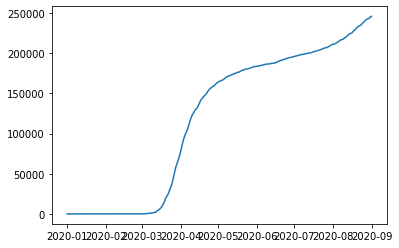

In [126]:
xx,xxf,yy = get_country_data('Germany','confirmed',firstdate='01/01/20',lastdate='06/5/20')
#plt.plot(xx,xxf)
plt.plot(xx,yy)
plt.savefig('tst.pdf')

In [100]:
plt.savefig('tst.pdf')

<Figure size 432x288 with 0 Axes>

In [151]:
xx,xxf,yy = get_country_data('Germany','confirmed',firstdate='01/01/20',lastdate='06/5/20')
print(xxf)
print(yy)
xx,xxf,yy1 = get_country_data('Germany','recovered',firstdate='01/01/20',lastdate='06/5/20')
print(yy)
xx,xxf,yy2 = get_country_data('Germany','deaths',firstdate='01/01/20',lastdate='06/5/20')
print(yy)
y = [[yy[i],yy1[i],yy2[i]] for i in range(len(yy))]
print(y)

[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0, 41.0, 42.0, 43.0, 44.0, 45.0, 46.0, 47.0, 48.0, 49.0, 50.0, 51.0, 52.0, 53.0, 54.0, 55.0, 56.0, 57.0, 58.0, 59.0, 60.0, 61.0, 62.0, 63.0, 64.0, 65.0, 66.0, 67.0, 68.0, 69.0, 70.0, 71.0, 72.0, 73.0, 74.0, 75.0, 76.0, 77.0, 78.0, 79.0, 80.0, 81.0, 82.0, 83.0, 84.0, 85.0, 86.0, 87.0, 88.0, 89.0, 90.0, 91.0, 92.0, 93.0, 94.0, 95.0, 96.0, 97.0, 98.0, 99.0, 100.0, 101.0, 102.0, 103.0, 104.0, 105.0, 106.0, 107.0, 108.0, 109.0, 110.0, 111.0, 112.0, 113.0, 114.0, 115.0, 116.0, 117.0, 118.0, 119.0, 120.0, 121.0, 122.0, 123.0, 124.0, 125.0, 126.0, 127.0, 128.0, 129.0, 130.0, 131.0, 132.0, 133.0, 134.0, 135.0, 136.0, 137.0, 138.0, 139.0, 140.0, 141.0, 142.0, 143.0, 144.0, 145.0, 146.0, 147.0, 148.0, 149.0, 150.0, 151.0, 152.0, 153.0, 154.0, 155.0, 156.0, 157.0, 158

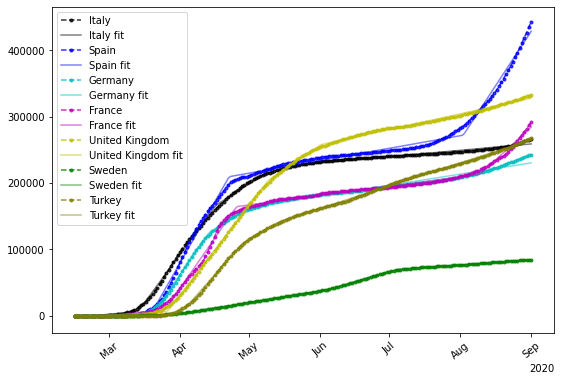

In [106]:
plotCountry_(['Italy','Spain','Germany','France','United Kingdom','Sweden','Turkey'],
             'confirmed','cum_av_weekly',firstdate='02/15/20',lastdate='09/1/20',fittype='piecewise-linear',nsegments=4)
plt.title("");
ax = plt.gca() #get axis handle
#xx = ax.lines[0].get_xdata()
#if len(xx)>len(dat):
#    for i in range(len(xx)-209):
#        dat = [(0,0)] + dat
#plt.plot(xx,[450000*d[0] for d in dat],linewidth=5,color='salmon',alpha=0.5,linestyle='--')
#plt.savefig("covid-19-caution/figures/fig1a.pdf",bbox_inches='tight')

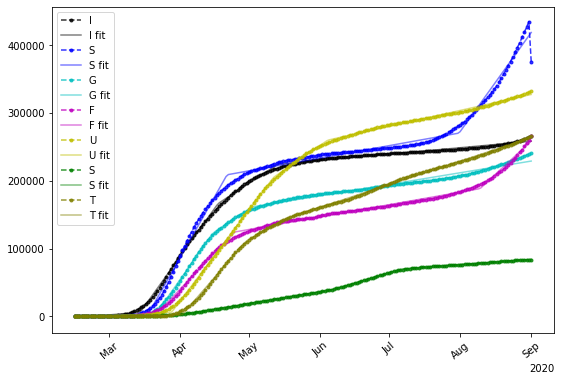

In [108]:
# repeat same plot but this time using the OWID database
# NB firstdate and lastdate inside data set are not working for plots : check this out
plotCountry_(['Italy','Spain','Germany','France','United Kingdom','Sweden','Turkey'],
             'confirmed','cum_av_weekly',firstdate='02/15/20',lastdate='09/1/20',fittype='piecewise-linear',nsegments=4,database='owid')
plt.title("");
ax = plt.gca() #get axis handle

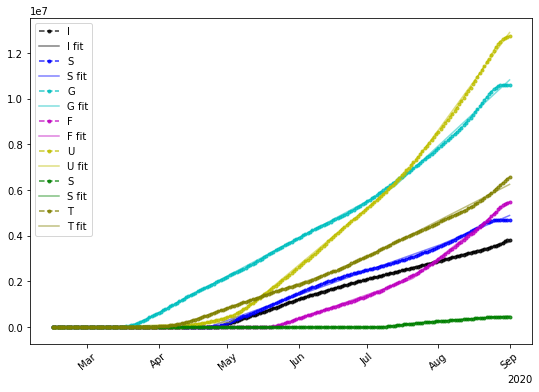

In [109]:
# repeat same plot but this time using tests data from the OWID database
# CAREFUL : we still need to distinguish the different types of testing data by cases or samples
plotCountry_(['Italy','Spain','Germany','France','United Kingdom','Sweden','Turkey'],
             'tests','cum_av_weekly',firstdate='02/15/20',lastdate='09/1/20',fittype='piecewise-linear',database='owid')
plt.title("");
ax = plt.gca() #get axis handle

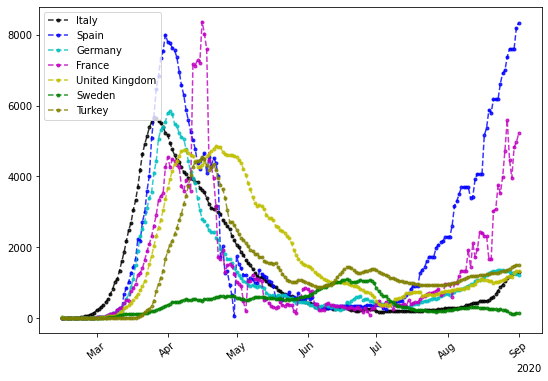

In [110]:
plotCountry_(['Italy','Spain','Germany','France','United Kingdom','Sweden','Turkey'],
            'confirmed','daily_av_weekly',firstdate='02/15/20',lastdate='09/1/20')
plt.title("");
# plt.plot(xx,[450000*d[1] for d in dat],linewidth=6,color='salmon',alpha=0.5,linestyle='--');
# plt.savefig("covid-19-caution/figures/fig1b.pdf",bbox_inches='tight')

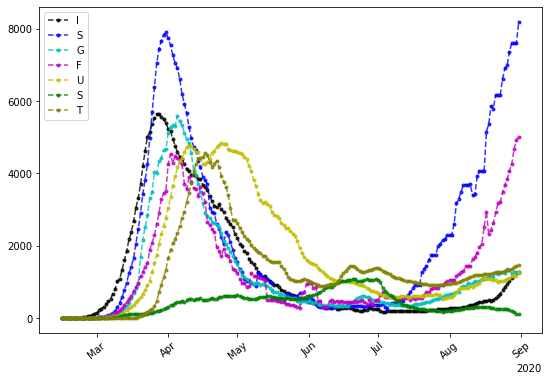

In [112]:
plotCountry_(['Italy','Spain','Germany','France','United Kingdom','Sweden','Turkey'],
            'confirmed','daily_av_weekly',firstdate='02/15/20',lastdate='08/31/20',database='owid')
plt.title("");
# plt.plot(xx,[450000*d[1] for d in dat],linewidth=6,color='salmon',alpha=0.5,linestyle='--');
# plt.savefig("covid-19-caution/figures/fig1b.pdf",bbox_inches='tight')

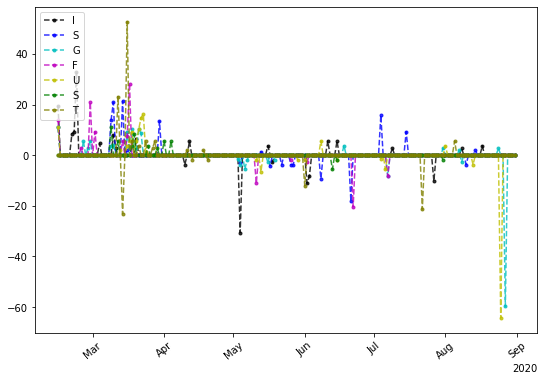

In [113]:
#stringency
plotCountry_(['Italy','Spain','Germany','France','United Kingdom','Sweden','Turkey'],
            'stringency','daily',firstdate='02/15/20',lastdate='08/31/20',database='owid')
plt.title("");
# plt.plot(xx,[450000*d[1] for d in dat],linewidth=6,color='salmon',alpha=0.5,linestyle='--');
# plt.savefig("covid-19-caution/figures/fig1b.pdf",bbox_inches='tight')

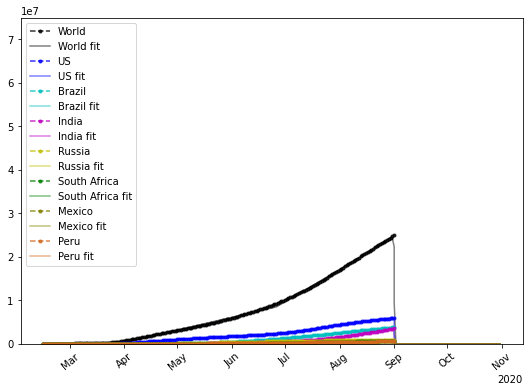

In [157]:
plotCountry_(['World','US','Brazil','India','Russia','South Africa','Mexico','Peru'],'confirmed',
             'cum_av_weekly',firstdate='02/15/20',lastdate='11/1/20',maxyval=75000000,fittype='piecewise-linear',nsegments=5)
plt.title("");
#plt.savefig("covid-19-caution/figures/fig1c.pdf",bbox_inches='tight')

In [ ]:
plotCountry_(['World','US','Brazil','India','Russia','South Africa','Mexico','Peru'],
             'confirmed','daily_av_weekly',firstdate='02/15/20',lastdate='08/1/20',maxyval=90000)
plt.title("");
#plt.savefig("covid-19-caution/figures/fig1d.pdf",bbox_inches='tight')

In [ ]:
plotCountry(['US','Brazil','India','Russia','South Africa','Mexico','Peru'],'deaths','daily_av_weekly',firstdate='02/15/20',lastdate='08/1/20')

In [ ]:
plotCountry(['Italy','Germany','Sweden','Spain'],'confirmed','daily_av_weekly',firstdate='01/01/20',lastdate='06/5/20')

In [ ]:
plotCountry(['Italy','Turkey','Germany','Russia','Brazil','United Kingdom','Spain'],'confirmed','daily_av_weekly',firstdate='01/01/20',lastdate='06/5/20')

In [ ]:
plotCountry(('Australia','New South Wales'),'confirmed','cumulative',None)
#plotCountry(('Austria',''))

In [ ]:
plotCountry('Italy','deaths')
plotCountry('Italy','confirmed')
plotCountry('Italy','recovered')

In [ ]:
plotCountry('World','deaths')
plotCountry('World','confirmed')
plotCountry('World','recovered')

In [ ]:
plotCountry(['Italy','United Kingdom','Spain','France','Germany'],'deaths','daily_av_weekly')

In [ ]:
plotCountry(('Germany',''),'deaths','daily',step='step')

In [ ]:
plotCountry(('Germany',''),'deaths','daily_av_weekly',step='step')

In [ ]:
plotCountry('Brazil','deaths','daily_av_weekly',step='step')

In [ ]:
countries_jhu

In [ ]:
print("number of countries",len(countries_jhu))
max_rows=10
max_cols=9
fig, axes = plt.subplots(nrows=max_rows, ncols=max_cols, figsize=(30,45))
minconfirmed=10000
count = 0
countries_jhu_min = countries_jhu.copy()
for idx, country  in enumerate(countries_jhu):
    maxconfirmed = maxCountry(country, datatype='confirmed', firstdate='02/15/20',lastdate='08/1/20')
    if maxconfirmed >= minconfirmed:
        count = count+1
    else:
        del countries_jhu_min[count]
print('len min countries',len(countries_jhu_min))
for idxx, country  in enumerate(countries_jhu_min):
    row = idxx // max_cols
    col = idxx % max_cols
    axes[row, col].axis("off")
    plotCountry_(country, datatype='confirmed', fittype='piecewise-linear',ax=axes[row, col],ax2=True,symbol='.',
                   firstdate='02/15/20',lastdate='08/1/20',nsegments=4)
for idx in range(len(countries_jhu_min),max_rows*max_cols):
    row = idx // max_cols
    col = idx % max_cols
    axes[row, col].axis("off")
plt.subplots_adjust(wspace=.5, hspace=.5)
plt.show()

In [ ]:
print("number of countries",len(countries_jhu))
minconfirmed=1000
count = 0
countries_jhu_min = countries_jhu.copy()
for idx, country  in enumerate(countries_jhu):
    maxconfirmed = maxCountry(country, datatype='deaths', firstdate='02/15/20',lastdate='08/1/20')
    if maxconfirmed >= minconfirmed:
        count = count+1
    else:
        del countries_jhu_min[count]
print('len min countries',len(countries_jhu_min))
max_cols=9
max_rows=1+(len(countries_jhu_min)-1)//9
fig, axes = plt.subplots(nrows=max_rows, ncols=max_cols, figsize=(30,30*max_rows/max_cols))
for idxx, country  in enumerate(countries_jhu_min):
    row = idxx // max_cols
    col = idxx % max_cols
    axes[row, col].axis("off")
    plotCountry_(country, datatype='deaths', fittype='piecewise-linear',ax=axes[row, col],ax2=True,symbol='.',
                   firstdate='02/15/20',lastdate='08/1/20',nsegments=4)
for idx in range(len(countries_jhu_min),max_rows*max_cols):
    row = idx // max_cols
    col = idx % max_cols
    axes[row, col].axis("off")
plt.subplots_adjust(wspace=.5, hspace=.5)
plt.show()

In [ ]:
print("number of countries",len(countries_jhu))
max_rows=36
max_cols=8
fig, axes = plt.subplots(nrows=max_rows, ncols=max_cols, figsize=(30,90))
for idx, country  in enumerate(countries_jhu):
    row = idx // max_cols
    col = idx % max_cols
    axes[row, col].axis("off")
    plotCountry(country, datatype='deaths', dataaccum='cum_av_weekly',fittype=None,ax=axes[row, col],ax2=True,symbol='.')
for idx in range(len(countries_jhu),max_rows*max_cols):
    row = idx // max_cols
    col = idx % max_cols
    axes[row, col].axis("off")
plt.subplots_adjust(wspace=.5, hspace=.5)
plt.show()

In [ ]:
print("number of countries",len(countries_jhu))
max_rows=36
max_cols=8
fig, axes = plt.subplots(nrows=max_rows, ncols=max_cols, figsize=(30,90))
for idx, country  in enumerate(countries_jhu):
    row = idx // max_cols
    col = idx % max_cols
    axes[row, col].axis("off")
    plotCountry(country, datatype='deaths', dataaccum='daily',fittype=None,ax=axes[row, col],ax2=True,symbol='.')
for idx in range(len(countries_jhu),max_rows*max_cols):
    row = idx // max_cols
    col = idx % max_cols
    axes[row, col].axis("off")
plt.subplots_adjust(wspace=.5, hspace=.5)
plt.show()

In [ ]:
print("number of countries",len(countries_jhu))
max_rows=36
max_cols=8
fig, axes = plt.subplots(nrows=max_rows, ncols=max_cols, figsize=(30,90))
for idx, country  in enumerate(countries_jhu):
    row = idx // max_cols
    col = idx % max_cols
    axes[row, col].axis("off")
    plotCountry(country, datatype='deaths', dataaccum='daily_av_weekly',fittype=None,ax=axes[row, col],ax2=True,symbol='.')
for idx in range(len(countries_jhu),max_rows*max_cols):
    row = idx // max_cols
    col = idx % max_cols
    axes[row, col].axis("off")
plt.subplots_adjust(wspace=.5, hspace=.5)
plt.show()

### Check daily figures with owid data

In [ ]:
def plotDaily(country_s, datatype):
    countries = []
    if isinstance(country_s,list):
        for country in country_s:
            if isinstance(country,str):
                country = (country,'')
            countries.append(country)
    elif isinstance(country_s,str):
        countries = [(country_s,'')]
    else:
        countries = [country_s]
            
    popkeyed = covid_ts[datatype]
    dates = popkeyed['dates']
    fmt = '%m/%d/%y'
    xx = [datetime.datetime.strptime(dd,fmt) for dd in dates ]
    day0 = datetime.datetime.strptime(dates[0],fmt)
    xxi = [Float((datetime.datetime.strptime(dd,fmt)-day0).days) for dd in dates ]
    # print(xxi)
    # locator = mdates.MonthLocator()
    locator = mdates.AutoDateLocator(minticks=5, maxticks=13)
    formatter= mdates.ConciseDateFormatter(locator)
    
    fig,ax = plt.subplots(1,1,figsize=(20,10))      
    colors =  ['k', 'b', 'c', 'm', 'y', 'g', 'r']
    i = 0
    for country in countries:
            yy = popkeyed[country]
            yyf = [Float(y) for y in yy]
            yyd = [0.]*len(yyf)
            yyd[0] = 0.
            for j in range(1,len(yyf)):
                yyd[j] = yyf[j]-yyf[j-1]
            ax.step(xx,yyd,label = country[0])
            # ax.plot(xx, yyd, color = colors[i], alpha=1, label = country[0])

            i = i+1

    #ax.plot(xx, yy, 'o--', color='black', alpha=0.3)
    
    
    ax.xaxis.set_major_formatter(formatter)
    ax.xaxis.set_major_locator(locator)
    for tick in ax.get_xticklabels():
        tick.set_rotation(40)
    if len(countries) == 1:
        plt.title(country[0]+'-'+country[1]+' '+datatype)
    else:
        plt.legend(loc="upper left")
        plt.title('countries '+datatype)

In [ ]:
plotDaily(['Italy','Turkey','Germany','Russia','Brazil','United Kingdom','Spain'],'deaths')

In [ ]:
plotDaily(['Germany'],'deaths')

## OWID data

In [49]:
owid_file = '../covid-19-owid/public/data/owid-covid-data.csv'
covid_owid = []
with open(owid_file,'r',newline='') as fp:
    myreader = csv.DictReader(fp,delimiter=',')
#    rows = list(itertools.islice(myreader,4))
    for row in myreader:
        covid_owid.append(row)

In [50]:
covid_owid[0].keys()

odict_keys(['iso_code', 'continent', 'location', 'date', 'total_cases', 'new_cases', 'new_cases_smoothed', 'total_deaths', 'new_deaths', 'new_deaths_smoothed', 'total_cases_per_million', 'new_cases_per_million', 'new_cases_smoothed_per_million', 'total_deaths_per_million', 'new_deaths_per_million', 'new_deaths_smoothed_per_million', 'new_tests', 'total_tests', 'total_tests_per_thousand', 'new_tests_per_thousand', 'new_tests_smoothed', 'new_tests_smoothed_per_thousand', 'tests_per_case', 'positive_rate', 'tests_units', 'stringency_index', 'population', 'population_density', 'median_age', 'aged_65_older', 'aged_70_older', 'gdp_per_capita', 'extreme_poverty', 'cardiovasc_death_rate', 'diabetes_prevalence', 'female_smokers', 'male_smokers', 'handwashing_facilities', 'hospital_beds_per_thousand', 'life_expectancy'])

In [51]:
set([(d['iso_code'],d['location']) for d in covid_owid])

{('', 'International'),
 ('ABW', 'Aruba'),
 ('AFG', 'Afghanistan'),
 ('AGO', 'Angola'),
 ('AIA', 'Anguilla'),
 ('ALB', 'Albania'),
 ('AND', 'Andorra'),
 ('ARE', 'United Arab Emirates'),
 ('ARG', 'Argentina'),
 ('ARM', 'Armenia'),
 ('ATG', 'Antigua and Barbuda'),
 ('AUS', 'Australia'),
 ('AUT', 'Austria'),
 ('AZE', 'Azerbaijan'),
 ('BDI', 'Burundi'),
 ('BEL', 'Belgium'),
 ('BEN', 'Benin'),
 ('BES', 'Bonaire Sint Eustatius and Saba'),
 ('BFA', 'Burkina Faso'),
 ('BGD', 'Bangladesh'),
 ('BGR', 'Bulgaria'),
 ('BHR', 'Bahrain'),
 ('BHS', 'Bahamas'),
 ('BIH', 'Bosnia and Herzegovina'),
 ('BLR', 'Belarus'),
 ('BLZ', 'Belize'),
 ('BMU', 'Bermuda'),
 ('BOL', 'Bolivia'),
 ('BRA', 'Brazil'),
 ('BRB', 'Barbados'),
 ('BRN', 'Brunei'),
 ('BTN', 'Bhutan'),
 ('BWA', 'Botswana'),
 ('CAF', 'Central African Republic'),
 ('CAN', 'Canada'),
 ('CHE', 'Switzerland'),
 ('CHL', 'Chile'),
 ('CHN', 'China'),
 ('CIV', "Cote d'Ivoire"),
 ('CMR', 'Cameroon'),
 ('COD', 'Democratic Republic of Congo'),
 ('COG', 'Cong

In [52]:
countries = list(set([dd['iso_code'] for dd in covid_owid]))

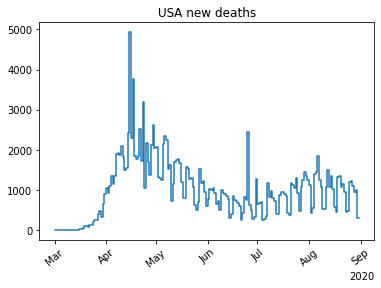

In [53]:
deathUSA = [(dd['date'],dd['new_deaths']) for dd in covid_owid if dd['iso_code']=='USA']

fmt = '%Y-%m-%d'
xx = [datetime.datetime.strptime(dd[0],fmt) for dd in deathUSA if int(float(dd[1]))>0 ]
yy = [int(float(dd[1])) for dd in deathUSA if int(float(dd[1]))>0 ]

locator = mdates.MonthLocator()
formatter= mdates.ConciseDateFormatter(locator)

fig,ax = plt.subplots(1,1)
ax.step(xx,yy)
ax.xaxis.set_major_formatter(formatter)
ax.xaxis.set_major_locator(locator)
for tick in ax.get_xticklabels():
    tick.set_rotation(40)
plt.title('USA new deaths')
plt.show()

In [72]:
type('aaa')==str

True

In [78]:
def plotTargets(iso,targ='new_deaths'):
    global covid_owid
    if type(iso)==str:
        iso = [iso]
    
    yyy = []
    xxx = []
    
    for ii in iso:
        datt = [(dd['date'],dd[targ]) for dd in covid_owid if dd['iso_code']==ii]
        deathstr = 'death'+ii
        fmt = '%Y-%m-%d'

        start=False
        xx = [] ; yy = []
        for i in range(len(datt)):
            dd = datt[i]
            try:
                q = float(dd[1])
            except:
                try:
                    q = int(dd[1])
                except:
                    q = -1
            if q == 0 or q == -1:
                if start==False:
                    continue
                else:
                    pass
            else:
                if start==False:
                    start=True
            if start:
                xx.append(datetime.datetime.strptime(dd[0],fmt))
                yy.append(q)
            xxx.append(xx)
            yyy.append(yy)
        
#    xx = [datetime.datetime.strptime(dd[0],fmt) for dd in datt if float(dd[1])>0 ]
#    yy = [float(dd[1]) for dd in datt if int(float(dd[1]))>0 ]

    locator = mdates.MonthLocator()
    formatter= mdates.ConciseDateFormatter(locator)

    register_matplotlib_converters() # pandas made me do it
    fig,ax = plt.subplots(1,1,figsize=(10,8))
    for i in range(len(xxx)):
        ax.step(xxx[i],yyy[i])
    ax.xaxis.set_major_formatter(formatter)
    ax.xaxis.set_major_locator(locator)
    for tick in ax.get_xticklabels():
        tick.set_rotation(40)
        strtit = ''
        for ii in iso:
            strtit = strtit+ii+'-'
        strtit = strtit+targ
        plt.title(strtit)
    plt.show()

In [79]:
type(['aaa'])

list

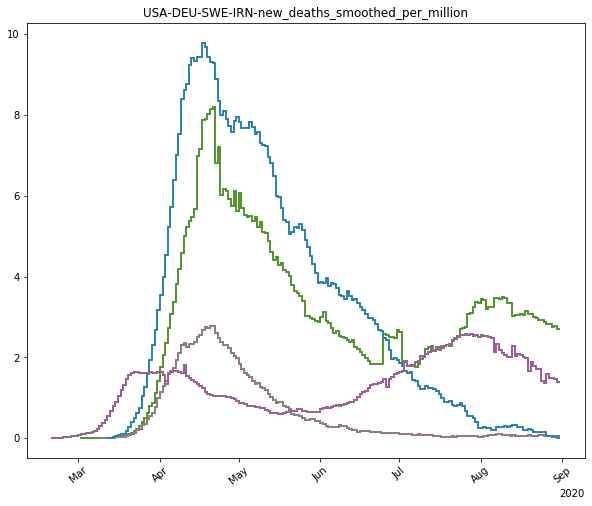

In [84]:
plotTargets(['USA','DEU','SWE','IRN'],'new_deaths_smoothed_per_million')

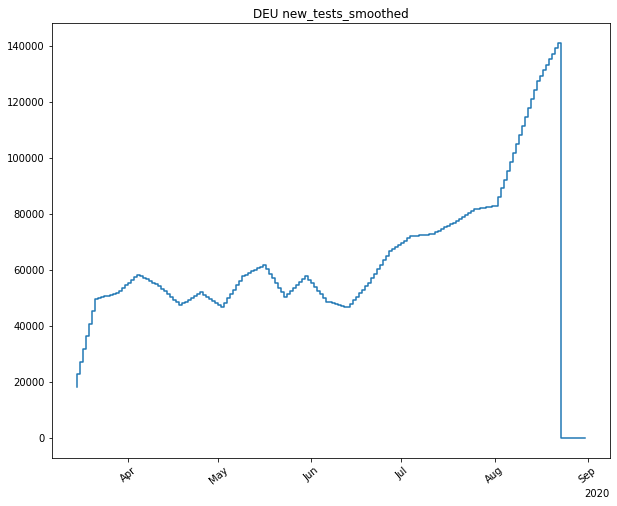

In [66]:
plotTarget('DEU','new_tests_smoothed')

In [ ]:
plotTarget('ESP','new_tests_smoothed')

In [ ]:
plotTarget('ITA','new_tests_smoothed')

In [ ]:
plotTarget('USA','new_tests_smoothed')

In [ ]:
plotTarget('DNK','new_tests_smoothed')

In [ ]:
plotTarget('RUS','new_tests_smoothed')

In [ ]:
plotTarget('DEU','new_cases')

In [ ]:
plotTarget('USA','new_cases')

In [ ]:
plotTarget('FRA','new_cases')

In [ ]:
plotTarget('SWE','new_cases')

In [ ]:
plotTarget('SWE','new_deaths')

In [ ]:
plotTarget('BRA','new_deaths')

## Oxford data

In [ ]:
owid_file = '../covid-policy-tracker/data/OxCGRT_latest.csv'
oxdat = []
with open(owid_file,'r',newline='') as fp:
    myreader = csv.DictReader(fp,delimiter=',')
#    rows = list(itertools.islice(myreader,4))
    for row in myreader:
        oxdat.append(row)
    

In [ ]:
oxdat[0].keys()

In [ ]:
countries = list(set([(dd['CountryName'],dd['CountryCode']) for dd in oxdat]))

In [ ]:
len(countries)

In [ ]:
[countries[i] for i in range(10)]

In [ ]:
dates = np.sort(list([dd['Date'] for dd in oxdat]))
dates_uniq = np.unique(dates)
dates_uniq

In [ ]:
foo = [(dd['Date'],dd['C1_School closing'],dd['C1_Flag']) for dd in oxdat if dd['CountryCode']=='USA']

In [ ]:
xx = foo[0:10]
print(xx)
xx=foo[-10:]
print(xx)

In [ ]:
ccodes = [cc[1] for cc in countries]
for cc in ccodes:
    foo = [(dd['CountryCode'],dd['RegionName']) for dd in oxdat if dd['CountryCode'] == cc]
    if len(set([x[1] for x in foo]))>1:
        print(cc)
        print( set([x[1] for x in foo]))


In [ ]:
[cc for cc in countries if cc[1]=='USA']

In [ ]:
foo = [(dd['Date'],dd['C1_School closing'],dd['C1_Flag']) 
       for dd in oxdat if dd['CountryCode']=='USA']

fmt = '%Y%m%d'
first = 31+22-1
xx = [datetime.datetime.strptime(dd[0],fmt) for dd in foo][first:]
yy = []
for dd in foo[first:]:
    try:
        yy.append(float(dd[1]))
    except:
        yy.append(float('NaN'))


locator = mdates.MonthLocator()
formatter= mdates.ConciseDateFormatter(locator)

fig,ax = plt.subplots(1,1)
ax.step(xx,yy)
ax.xaxis.set_major_formatter(formatter)
ax.xaxis.set_major_locator(locator)
for tick in ax.get_xticklabels():
    tick.set_rotation(40)
plt.title('USA')
plt.show()

Note:  no wildcard data:

In [ ]:
foo = [(dd['Date'],dd['CountryCode'],dd['M1_Wildcard']) 
       for dd in oxdat if dd['M1_Wildcard'] != '']



In [ ]:
foo


Notes:  
* first version of `datcodes` leaves out all flags (general vs. targeted implementation)
* 2nd version leaves out all variables measured in dollars

In [ ]:
datcodes = ['C1_School closing', 'C2_Workplace closing', 
            'C3_Cancel public events', 'C4_Restrictions on gatherings', 
            'C5_Close public transport', 'C6_Stay at home requirements', 
            'C7_Restrictions on internal movement', 'C8_International travel controls', 
            'E1_Income support', 'E2_Debt/contract relief', 'E3_Fiscal measures', 
            'E4_International support', 'H1_Public information campaigns', 
            'H2_Testing policy', 'H3_Contact tracing', 
            'H4_Emergency investment in healthcare', 'H5_Investment in vaccines']

datcodes = ['C1_School closing', 'C2_Workplace closing', 
            'C3_Cancel public events', 'C4_Restrictions on gatherings', 
            'C5_Close public transport', 'C6_Stay at home requirements', 
            'C7_Restrictions on internal movement', 'C8_International travel controls', 
            'E1_Income support', 'E2_Debt/contract relief', 
            'H1_Public information campaigns', 
            'H2_Testing policy', 'H3_Contact tracing']



In [ ]:
countrycodes = list(set([dd['CountryCode'] for dd in oxdat if Float(dd['ConfirmedCases'])>10000]))
len(countrycodes)

In [ ]:
countriesox = list(set([dd['CountryName'] for dd in oxdat if Float(dd['ConfirmedCases'])>10000]))

In [ ]:
len(countriesox)

In [ ]:
def Float(x):
    try:
        rtn = float(x)
    except:
        rtn = float('NaN')
    return rtn


In [ ]:
datcodes

In [ ]:
def get_codedat(countrycode='USA'):
    codedat = []
    foo = [[dd['Date']]+ [Float(dd[c]) for c in datcodes]
           for dd in oxdat if dd['CountryCode']==countrycode]
    return foo
    


In [ ]:
get_codedat()

### Stringency

In [ ]:
[x for x in oxdat[0]]

In [ ]:
country='DEU'
reg = '' # to get entire country for UK, USA
foo = [(dd['Date'],dd['StringencyIndex'],dd['C1_Flag']) 
       for dd in oxdat if dd['CountryCode']==country and dd['RegionName']==reg]

fmt = '%Y%m%d'
first = 31+22-1  # to get to Feb 22 where data starts
xx = [datetime.datetime.strptime(dd[0],fmt) for dd in foo][first:]
yy = []
for dd in foo[first:]:
    try:
        yy.append(float(dd[1]))
    except:
        yy.append(float('NaN'))


locator = mdates.MonthLocator()
formatter= mdates.ConciseDateFormatter(locator)

fig,ax = plt.subplots(1,1)
ax.step(xx,yy)
ax.xaxis.set_major_formatter(formatter)
ax.xaxis.set_major_locator(locator)
for tick in ax.get_xticklabels():
    tick.set_rotation(40)
plt.title(country+' Stringency')
plt.show()

In [ ]:
print("number of countries",len(countrycodes))

In [ ]:
def get_stringency(country):
    yy=[]
    foo = [(dd['Date'],dd['StringencyIndex'],dd['C1_Flag']) 
       for dd in oxdat if dd['CountryName']==country and dd['RegionName']=='']
    fmt = '%Y%m%d'
    first = 31+22-1  # to get to Feb 22 where data starts
    dates = [datetime.datetime.strptime(dd[0],fmt) for dd in foo][first:]
    for dd in foo[first:]:
        try:
            yy.append(float(dd[1]))
        except:
            yy.append(float('NaN'))
    return([dates,yy])
    

In [ ]:
foo = get_stringency('Germany')
plt.plot(foo[0],foo[1]);

In [ ]:
import matplotlib.dates as mdates


In [ ]:
max_rows=12
max_cols=8
idx = 0
fig, axes = plt.subplots(nrows=max_rows, ncols=max_cols, figsize=(20,40))
fig.autofmt_xdate()
for idx, country  in enumerate(countriesox):
    foo = get_stringency(country)
    row = idx // max_cols
    col = idx % max_cols
    axes[row, col].set_ylim((0,110))
    axes[row, col].xaxis.set_major_locator(plt.MaxNLocator(3))
    axes[row, col].fmt_xdata = mdates.DateFormatter('%Y-%m-%d')
    axes[row, col].plot(foo[0],foo[1])
    axes[row, col].set_title(country)
for idx in range(len(countriesox),max_rows*max_cols):
    row = idx // max_cols
    col = idx % max_cols
    axes[row, col].axis("off")

In [ ]:
len(countriesox)

In [ ]:
import pickle as pk

In [ ]:
dicstringency={}
for cc in countriesox:
    foo = get_stringency(cc)
    dicstringency[cc] = [x[1] for x in foo] # skip date
dates = [x[0] for x in foo]
stringency={}
stringency['dates'] = dates
stringency['data'] = dicstringency
pk.dump(stringency,open('stringency.pk','wb'))

### Response policy maps

* time along x axis 
* NaN same color as max value (typically 4)
* 12 rows for presence of 12 factors.  cf oxford codebook.md in ../covid-policy-tracker/documentation/.

In [ ]:
# for comaptibility with JHU data set first elt as 22nd Feb 2020
# assuming Oxford records start with Jan 1st 2020
first = 31+22-1

In [ ]:
foo = get_codedat('DEU')
foo = [f[1:] for f in foo]
plt.imshow(np.transpose(foo),cmap='hot',aspect='auto');
plt.title('DEU')


In [ ]:
foo = get_codedat('USA')[first:]
foo = [f[1:] for f in foo]
plt.imshow(np.transpose(foo),cmap='hot',aspect='auto');
plt.title("USA")

In [ ]:
foo = get_codedat('KOR')
foo = [f[1:] for f in foo]
plt.imshow(np.transpose(foo),cmap='hot',aspect='auto');

In [ ]:
foo = get_codedat('SWE')
foo = [f[1:] for f in foo]
plt.imshow(np.transpose(foo),cmap='hot',aspect='auto');

In [ ]:
print("number of countries",len(countrycodes))
max_rows=22
max_cols=8
fig, axes = plt.subplots(nrows=max_rows, ncols=max_cols, figsize=(20,40))
for idx, countrycode  in enumerate(countrycodes):
    foo = get_codedat(countrycode)
    foo = [f[1:] for f in foo]
    row = idx // max_cols
    col = idx % max_cols
    axes[row, col].axis("off")
    axes[row, col].imshow(np.transpose(foo),cmap='hot',aspect='auto',interpolation='none');
for idx in range(len(countrycodes),max_rows*max_cols):
    row = idx // max_cols
    col = idx % max_cols
    axes[row, col].axis("off")
plt.subplots_adjust(wspace=.05, hspace=.05)
plt.show()

In [ ]:
print(countrycodes)
#e.g.
countrycode = 'BOL'
foo = get_codedat(countrycode)
foo = [f[1:] for f in foo]
countrynames = [dd['CountryName'] for dd in oxdat if dd['CountryCode']==countrycode]
countryname = countrynames[0]
print(countryname)

In [ ]:
# aim here is to format x axis of imshow array as dates
# for working implementation see https://stackoverflow.com/questions/52574000/plotting-an-image-with-x-axis-as-time
# this commented out code does not work here
foo = get_codedat('FRA')
fmt = '%Y%m%d'

locator = mdates.MonthLocator()    # need to change locator to convert integers to dates first
formatter= mdates.ConciseDateFormatter(locator)
xx =[datetime.datetime.strptime(dd[0],fmt) for dd in foo]
# print(xx)
foo = [f[1:] for f in foo]
register_matplotlib_converters() # pandas made me do it
fig,ax = plt.subplots(1,1,figsize=(10,10))
# ax.xaxis_date()           # treats x axis as dates if start/finish date set appropriately
# plt.xlim(xx[0],xx[-1])   # this version produces right date axis but no data shown
# plt.xlim(0,(xx[-1]-xx[0]).days)  # this version keeps xaxis as integer -> errors
ax.imshow(np.transpose(foo),cmap='hot',aspect='auto')  # 
# ax.xaxis.set_major_formatter(formatter)
# ax.xaxis.set_major_locator(locator)
# for tick in ax.get_xticklabels():
#     tick.set_rotation(40)

plt.show()

## Combinations of data : Oxford policy plus JHU or OWID

In [ ]:
# translations from Oxford data base countries to JHU names
country_Oxford_JHU = {}
country_Oxford_JHU.update({('Cape Verde', ''):('Cabo Verde', '')})
country_Oxford_JHU.update({('Aruba', ''):('Netherlands', 'Aruba')})
country_Oxford_JHU.update({('Bermuda', ''):('United Kingdom', 'Bermuda')})
country_Oxford_JHU.update({('Hong Kong', ''):('China', 'Hong Kong')})
country_Oxford_JHU.update({('Czech Republic', ''):('Czechia', '')})
country_Oxford_JHU.update({('China', ''):('China', 'Total')})          # split in database : sums to Total need to be done
country_Oxford_JHU.update({('Slovak Republic', ''):('Slovakia', '')})
country_Oxford_JHU.update({('Congo', ''):('Congo (Brazzaville)', '')}) # two Congos, this is Rep. of Congo, other is Democratic Republic of Congo
country_Oxford_JHU.update({('Democratic Republic of Congo', ''):('Congo-Kinshasa','')})
country_Oxford_JHU.update({('Solomon Islands', ''):('Solomon Islands', '')}) # Not present in JHU list: sovereign state poln 650000
country_Oxford_JHU.update({('South Korea', ''):('Korea, South', '')})
country_Oxford_JHU.update({('Turkmenistan', ''):('Turkmenistan', '')}) # Not present in JHU list: 5.6M people in Central Asia
country_Oxford_JHU.update({('Myanmar', ''):('Thailand', '')})
country_Oxford_JHU.update({('United States', '') : ('US', '')})
country_Oxford_JHU.update({('Australia', ''):('Australia', 'Total')})  # split in database : sums to Total need to be done
country_Oxford_JHU.update({('Puerto Rico', ''):('United States','Puerto Rico')})   # not found in inspection of JHU list, territory of US
country_Oxford_JHU.update({('Palestine', ''):('West Bank and Gaza', '')})
country_Oxford_JHU.update({('Timor', ''):('Timor-Leste', '')})         # check two Timors, East Timor
country_Oxford_JHU.update({('Canada', ''):('Canada', 'Total')})        # split in database : sums to Total need to be done
country_Oxford_JHU.update({('Greenland', ''):('Denmark', 'Greenland')})
country_Oxford_JHU.update({('Macao', ''):('China', 'Macau')})
country_Oxford_JHU.update({('Kyrgyz Republic', ''):('Kyrgyzstan', '')})
country_Oxford_JHU.update({('Taiwan', ''):('Taiwan*', '')})
country_Oxford_JHU.update({('Guam', ''):('United States','Guam')})     # not found in inspection of JHU list, territory of US

In [ ]:
# print country data and corresponding JHU confirmed cases if available on same timescale
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(20,20))
countrycode='ITA'
foo = get_codedat(countrycode)
pdata = np.transpose([f[1:] for f in foo])
xmin = 0
xmax = pdata[-1,0]
ymin = 0
ymax = 200000
countrynames = [dd['CountryName'] for dd in oxdat if dd['CountryCode']==countrycode]
countryname = countrynames[0]
if (countryname,'') not in countries_jhu:
    print(countryname)
    countryname = country_Oxford_JHU[(countryname,'')]
#axes.axis("off")

# axes.imshow(pdata,cmap='hot',aspect='auto',interpolation='none',origin='lower',extent=[0,xmax,0,ymax])
    # axes[row, col].pcolor(pdata,cmap='hot')
    # print(countryname)
    # xxx=range(len(pdata[0]))
# plotCountry(countryname, datatype='confirmed', dataaccum='cumulative',fittype=None,ax=axes,
#                symbol='.',firstdate='01/01/20',lastdate='05/21/20',intdates=True)
axes.imshow(pdata,cmap='hot',aspect='auto',interpolation='none',origin='lower')
axes2 = axes.twinx()
plotCountry(countryname, datatype='confirmed', dataaccum='daily', fittype=None,ax=axes, ax2=axes2,
                symbol='o--',firstdate='01/01/20',lastdate='05/21/20',intdates=True,linecolor='green')

# plt.subplots_adjust(wspace=.05, hspace=.05)
plt.show()

In [ ]:
country_Oxford_JHU.update({('Democratic Republic of Congo', ''):('Congo-Kinshasa','')})

In [ ]:
# print country data and corresponding JHU confirmed cases if available on same timescale
print("number of countries",len(countrycodes))
max_rows=22
max_cols=8
fig, axes = plt.subplots(nrows=max_rows, ncols=max_cols, figsize=(30,60))
for idx, countrycode  in enumerate(countrycodes):
    foo = get_codedat(countrycode)
    # print(np.transpose(foo) # NB need to transpose to get dates on x axis
    foo = [f[1:] for f in foo]
    
    countrynames = [dd['CountryName'] for dd in oxdat if dd['CountryCode']==countrycode]
    countryname = countrynames[0]
    if (countryname,'') not in countries_jhu:
        # print(countryname)
        countryname = country_Oxford_JHU[(countryname,'')]
    row = idx // max_cols
    col = idx % max_cols
    axes[row, col].axis("off")
    axes[row, col].imshow(np.transpose(foo),cmap='hot',aspect='auto',interpolation='none',origin='lower')
    # axes[row, col].pcolor(np.transpose(foo),cmap='hot')
    # print(countryname)
    # xxx=range(len(np.transpose(foo)[0]))
    axes2=axes[row, col].twinx
    plotCountry(countryname, datatype='confirmed', dataaccum='daily_av_weekly',fittype=None,ax=axes[row,col],ax2=axes2,
                symbol='.',firstdate='01/01/20',lastdate='05/21/20',intdates=True,linecolor='green')

for idx in range(len(countrycodes),max_rows*max_cols):
    row = idx // max_cols
    col = idx % max_cols
    axes[row, col].axis("off")
    
plt.subplots_adjust(wspace=.5, hspace=.2)
plt.show()

In [ ]:

# print country data and corresponding JHU confirmed cases if available on same timescale
print("number of countries",len(countrycodes))
max_rows=22
max_cols=8
fig, axes = plt.subplots(nrows=max_rows, ncols=max_cols, figsize=(30,60))
for idx, countrycode  in enumerate(countrycodes):
    foo = get_codedat(countrycode)
    # print(np.transpose(foo) # NB need to transpose to get dates on x axis
    foo = [f[1:] for f in foo]
    
    countrynames = [dd['CountryName'] for dd in oxdat if dd['CountryCode']==countrycode]
    countryname = countrynames[0]
    if (countryname,'') not in countries_jhu:
        # print(countryname)
        countryname = country_Oxford_JHU[(countryname,'')]
    row = idx // max_cols
    col = idx % max_cols
    axes[row, col].axis("off")
    axes[row, col].imshow(np.transpose(foo),cmap='hot',aspect='auto',interpolation='none',origin='lower')
    # axes[row, col].pcolor(np.transpose(foo),cmap='hot')
    # print(countryname)
    # xxx=range(len(np.transpose(foo)[0]))
    axes2=axes[row, col].twinx
    plotCountry(countryname, datatype='confirmed', fittype=None,ax=axes[row,col],ax2=axes2,
                symbol='.',firstdate='01/01/20',lastdate='05/21/20',intdates=True,linecolor='green')

for idx in range(len(countrycodes),max_rows*max_cols):
    row = idx // max_cols
    col = idx % max_cols
    axes[row, col].axis("off")
    
plt.subplots_adjust(wspace=.5, hspace=.2)
plt.show()